```{index} single: Goal Seeking
```
```{index} single: Targeting a result
```

# Targeting a specific result (Goal seeking)


Sometimes rather than asking the model the impact of some specific change, a researcher will want to ask, what level of some variable would be needed to generate a specific result. For example, if a specific debt to GDP ratio were desired, what level of taxation would be required to attain it given all of the other assumptions in a given baseline.

This chapter explains how to use `modelflow` to target specific outputs.

Effectively 5 steps are required:

1. Load a pre-existing model in Modelflow
2. Define the targeted value and the instruments by which to obtain it
3. Simulate the model
4. Visualize the results

## Prepare workspace

In [1]:
%matplotlib inline

In [2]:
# HIDDEN in jupyterbook 
#This is code to manage dependencies if the notebook is executed in the google colab cloud service
if 'google.colab' in str(get_ipython()):
  import os
  os.system('apt -qqq install graphviz')
  os.system('pip -qqq install ModelFlowIb ipysheet  --no-dependencies ')

%load_ext autoreload
%autoreload 2

In [3]:
from modelclass import model 

model.widescreen()

## Load a  model, data and descriptions 
The file `pak.pcim` contains a dump of model equations, dataframe, simulation options and variable descriptions for a climate ware model of Pakistan described in {cite:author}`Burns2021`. 

The command `mpak,initial = model.modelload('../models/pak.pcim')` loads the model and data and initializes the model object mpak with the associated equations and data.  The initial results are stored in the dataframe initial that is created as a copy of basedf with the call to the method `modelload()`.

The model is then solved and the resulting dataframe assigned to the object baseline.

In [4]:
mpak,initial = model.modelload('../models/pak.pcim')

file read:  C:\modelflow manual\papers\mfbook\content\models\pak.pcim


In [5]:
baseline = mpak(initial,2022,2100,alfa=0.7,silent=1)

```{index} single: Goal Seeking; Defining Targets 
```
```{index} single: Targeting a result; Defining Targets
```
```{index} single: Goal Seeking; Defining Instruments
```
```{index} single: Targeting a result; Defining Instruments
```

### Define targets and instruments

For the purpose of this exercise a simulation to find the level of carbon taxes necessary to reduce the totality of emissions in Pakistan to 50% of their baseline values by 2100 is run.

The target variable is total emissions :  **PAKCCEMISCO2TKN**

The instruments (the variables that the solver will adjust to achieve the target) are the three carbon taxes in the model:



In [6]:
mpak['PAKGGREVCO2?ER'].des

PAKGGREVCO2CER : Carbon tax on coal (USD/t)
PAKGGREVCO2GER : Carbon tax on gas (USD/t)
PAKGGREVCO2OER : Carbon tax on oil (USD/t)


As a first step, create a list of target variables `target_var` and instruments `instruments` comprised of these variable names.

In [7]:
target_var = ['PAKCCEMISCO2TKN']
instruments = [['PAKGGREVCO2CER','PAKGGREVCO2GER', 'PAKGGREVCO2OER']]

```{index} single: Goal Seeking; Target trajectory
```
```{index} single: Targeting a result; Target trajectory
```


### The  target trajectory. 
To find the level of the instrument variables necessary to achive the target the target must itself be defined. 

In this case the target is to reduce the level of emissions in 2100 by 50%.

In [8]:
reduction_percent = 75   # Input the desired reduction in percent. 

The targetted level of emissions in 2100 is therefore 

$PAKCCEMISCO2TKN^{target}_{2100} = PAKCCEMISCO2TKN^{baseline}_{2100} (1-50/100)$

If we assume the target is to be achieved gradually, the target growth rate can be calculated as:

target growth rate:  $\dfrac{PAKCCEMISCO2TKN^{target}_{2100}}{PAKCCEMISCO2TKN^{baseline}_{2022}}^{\frac{1}{2100-2200}}-1$

With this growth rate emission emission in 2100 will have the desired reduction

In pandas speak this is done in the code below. 

In [9]:
bau_2100        = baseline.loc[2100,'PAKCCEMISCO2TKN']
bau_2022        = baseline.loc[2022,'PAKCCEMISCO2TKN']

target_2100        = bau_2100 * (1-reduction_percent/100)
target_growth_rate = (target_2100/bau_2022)**(1/(2100-2022))-1

bau_growth_rate = (bau_2100/bau_2022)**(1/(2100-2022))-1

print(f"Business as usual Emission value in 2100: {bau_2100:13,.0f}")
print(f"Business as usual Emission value in 2100: {target_2100:13,.0f}")
print(f"Business as usual growth rate in percent: {bau_growth_rate:13,.1%}")
print(f"Target growth rate in percent           : {target_growth_rate:13,.1%}")

Business as usual Emission value in 2100: 1,950,344,715
Business as usual Emission value in 2100:   487,586,179
Business as usual growth rate in percent:          2.8%
Target growth rate in percent           :          1.0%


```{index} single: Goal Seeking; Example of creating dataframe
```
```{index} single: Example of creating dataframe
```

### Create a dataframe with the target 
Now a dataframe can be created using the growth rate for the target variable calculated above. 

The dataframe should only contain columns for the target variables - here only one. 

In [10]:
target_before = baseline.loc[2022:,['PAKCCEMISCO2TKN']]     # Create dataframe with only the target variable 
# create a target dataframe with a projection of the target variable 
target = target_before.upd(f'<2023 2100> PAKCCEMISCO2TKN =growth {100*target_growth_rate}')



### Calculate the values of the instruments needed to achieve the target 





In [11]:
%%time
_ = mpak.invert(baseline,                  # Invert calls the target instrument device                   
                targets = target,                   
                instruments=instruments,
                DefaultImpuls=2,              # The default impulse instrument variables 
                defaultconv=2.0,              # Convergergence criteria for targets
                varimpulse=False,             # Changes in instruments in each iteration are carried over to the future
                nonlin=15,                    # If no convergence in 15 iteration recalculate jacobi 
                silent=1,                     # Don't show iteration output (try 1 for showing)
                delay=0,
               )

Finding instruments :   0%|          | 0/79

No convergense in target instrument in 2043, maxiter=30


Exception: No convergence 

```{index} single: Report writing: Annotated chart
```


### Make a graph and decorate with a line and an annotation
Also show the tax rate



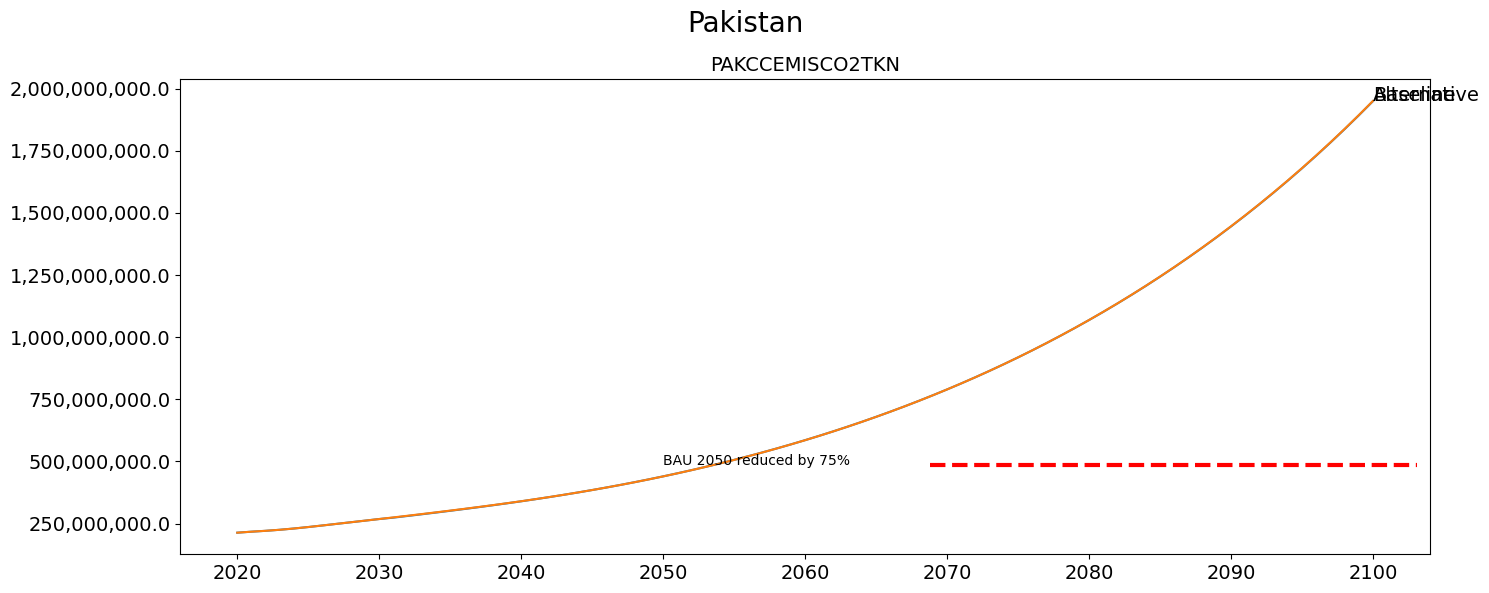

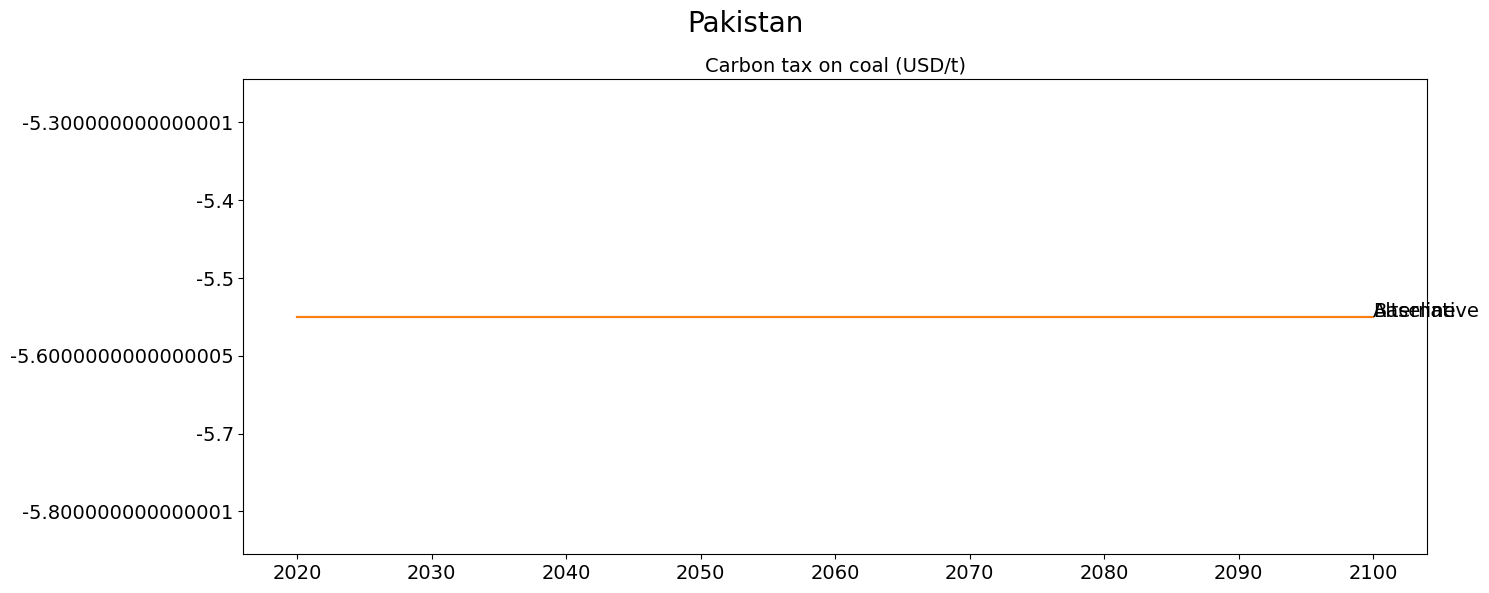

In [12]:
with mpak.set_smpl(2020,2100):    # change if you want another  timeframe 
    fig = mpak[f'PAKCCEMISCO2TKN' ].plot_alt(title='Pakistan')
    fig.axes[0].axhline( target_2100,
                                  xmin=0.6,
                                  xmax = 0.99,
                                  linewidth=3, 
                                  color='r', ls='dashed')

    fig.axes[0].annotate(f'BAU 2050 reduced by {reduction_percent}%', xy=(2050,target_2100 ))
    fig2 = mpak[f'PAKGGREVCO2CER' ].plot_alt(title=f'Pakistan'); 


### Look at selected variables with the [] operator 
If you want to look at multiple variables the index [] operator can be used to select the variables to analyze/visualize. Here only a few operations will be shown. There is more [here](index-operator)

In [13]:
mpak['PAKNYGDPMKTPKN PAKNECONGOVTKN PAKNEGDIFTOTKN PAKNEIMPGNFSKN PAKCCEMISCO2TKN']

```{index} single: Goal Seeking; multiple instruments - different weights
```
```{index} single: Targeting a result;  multiple instruments - different weights
```

## Weighting the instruments  

When using multiple instruments for a single target, the modeler may  want to privilege changes in one instrument over another by specifying weights to attach to each.  In the example below, specific weights are attached to the instruments instructing the solver to place twice as much emphasis on adjusting the carbon tax on coal emissions (as compared with the other two carbon taxes).  

In [14]:
new_instruments =[[('PAKGGREVCO2CER',10),
                   ('PAKGGREVCO2GER', 5),
                   ('PAKGGREVCO2OER',5)]]


_ = mpak.invert(baseline,targets = target,
                            instruments=new_instruments,
                          DefaultImpuls=1,
                                defaultconv=2.0,varimpulse=True,nonlin=15,silent=1)

Finding instruments :   0%|          | 0/79

No convergense in target instrument in 2036, maxiter=30


Exception: No convergence 

In [ ]:
with mpak.set_smpl(2020,2100):    # change if you want another  timeframe 
    fig = mpak[f'PAKCCEMISCO2TKN' ].plot_alt(title='Pakistan')
    fig.axes[0].axhline( target_2100,
                                  xmin=0.6,
                                  xmax = 0.99,
                                  linewidth=3, 
                                  color='r', ls='dashed')

    fig.axes[0].annotate(f'BAU 2050 reduced by {reduction_percent}%', xy=(2050,target_2100*1.015 ))

The final period carbon tax on Coal is twice as large as on natural gas or crude oil, reflecting the higher weighting attached to the Coal carbon tax when the instruments were assigned.

In [ ]:
mpak['PAKGGREVCO2CER PAKGGREVCO2GER PAKGGREVCO2OER' ].df.loc[2090:2100]

In [ ]:
mpak.PAKCCEMISCO2TKN.dash 

In [ ]:
mpak.PAKNVOILNIMPQN.dash